In [8]:
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH=12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [103]:

##Running Proxima without reference data (true)
experiments_true = [
    'true-run_rs1',
    'true-run_rs2',
    'true-run_rs3',
    'true-run_rs4',
    'true-run_rs5',
    'true-run_rs6',
    'true-run_rs7',
    'true-run_rs8',
    'true-run_rs9',
    'true-run_rs10',
]

#Running Proxima with reference data
experiments = [
    'dynLns_r1',
    'dynLns_r3',## Need to run dynamic with ref. data, seed =2
    'dynLns_r4',
    'dynLns_r5',
    'dynLns_r6',
    'dynLns_r7',
    'dynLns_r8',
    'dynLns_r9',
    'dynLns_r10',
]

#Running FIXED(0.3,50)
experiment_ss = [
    'ss-true_rs1',
    'ss-true_rs2',
    'ss-true_rs3',
    'ss-true_rs4',
    'ss-true_rs5',
    'ss-true_rs6',
    'ss-true_rs7',
    'ss-true_rs8',
    'ss-true_rs9',
    'ss-true_rs10',
]
root_path = '../proxima_data'

## ROG results of Target function

In [104]:
rog_hf = defaultdict(list)
run_name = 'random-seed_runs/hf_rog'
file = "/".join([root_path, run_name,'result*'])
for f in glob.glob(file):
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[1].split(".json")[0]
    temp = str(int(float(temp)))
    with open(f) as data:
        rog_hf[temp].append(
            json.loads(
                data.read()
            ).get("r_g", None).get("statistic", None)
        )
        
temps = []; rogs_median = []; rogs_std = []
for k, v in rog_hf.items():
    temps.append(float(k))
    rogs_median.append(np.median(v))
    #rogs_median.append(np.mean(v))
    rogs_std.append(np.std(v)/np.sqrt(len(v)-1))

temps, rogs_median, rogs_std = zip(*sorted(zip(temps, rogs_median, rogs_std)))

In [105]:
rog_hf.keys()

dict_keys(['400', '300', '500', '100', '200', '900', '600', '800', '700', '1000'])

## ROG results for true simulations w/ Proxima

In [106]:
rog_dynLns = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/true-run*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_dynLns[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_dynLns = []; rogs_dynLns_median = []; rogs_dynLns_std = []
for k, v in rog_dynLns.items():
    temps_dynLns.append(float(k))
    rogs_dynLns_median.append(np.median(v))
    #rogs_dynLns_median.append(np.mean(v))
    rogs_dynLns_std.append(np.std(v)/np.sqrt(len(v)))

temps_dynLns, rogs_dynLns_median, rogs_dynLns_std = zip(
    *sorted(zip(temps_dynLns, rogs_dynLns_median, rogs_dynLns_std))
)

In [107]:
rog_dynLns.keys()

dict_keys(['200', '700', '100', '1000', '300', '900', '500', '800', '600', '400'])

## ROG results for Simple surrogate 
Fixed Parameters - 0.3, 50

In [108]:
rog_SS = defaultdict(list)

## True runs - MC simulations not using reference data, running Proxima, lazy training, no surrogate limit
## dynLNS - Proxima, with reference data (lazy training, no surrogate limit)
#run_name = 'random-seed_runs/dynLns_*'
run_name = 'random-seed_runs/ss-true*'
dirs = "/".join([root_path, run_name])

for d in glob.glob(dirs):
    
    subdirs = "/".join([d, "*"])
    for s in glob.glob(subdirs):
    
        control_fn = os.path.basename(s).split('_')
        temp = control_fn[6]
        try:
            with open(s + '/result.json') as data:
                rog_SS[temp].append(
                    json.loads(
                        data.read()
                    ).get("r_g", None).get("statistic", None)
                )
        except:
            pass

temps_SS = []; rogs_SS_median = []; rogs_SS_std = []
for k, v in rog_SS.items():
    temps_SS.append(float(k))
    #rogs_SS_median.append(np.median(v))
    rogs_SS_median.append(np.mean(v))
    rogs_SS_std.append(np.std(v)/np.sqrt(len(v)))

temps_SS, rogs_SS_median, rogs_SS_std = zip(
    *sorted(zip(temps_SS, rogs_SS_median, rogs_SS_std))
)

In [109]:
rog_SS.keys()

dict_keys(['1000', '700', '400', '800', '600', '200', '900', '500', '100', '300'])

In [110]:
#rogs_SS_median
## Side calculations

In [111]:
good_std = np.std([r for r in rog_dynLns['400'] if r < 0.275])

In [112]:
good_mean = np.median([r for r in rog_dynLns['400'] if r < 0.275])

In [113]:
full_std = np.std([r for r in rog_dynLns['400'] if r < 0.4])
full_mean = np.median([r for r in rog_dynLns['400'] if r < 0.4])

In [114]:
outlier = 0.2784916750097781 
(outlier - full_mean)/full_std

3.3079459184550775

In [115]:
outlier = 0.2784916750097781 
(outlier - good_mean)/good_std

19.618690558621616

In [116]:
mylist = [r for r in rog_dynLns['400'] if r < 0.3]

In [117]:
sorted(mylist)

[0.2736137359693603,
 0.2736287045348181,
 0.2737594994850852,
 0.27376152580691054,
 0.2737999073837394,
 0.27392838512020684,
 0.27394275298367926,
 0.2742383749188642,
 0.2743403945366164,
 0.2784916750097781]

# Median ROG vs Temperature

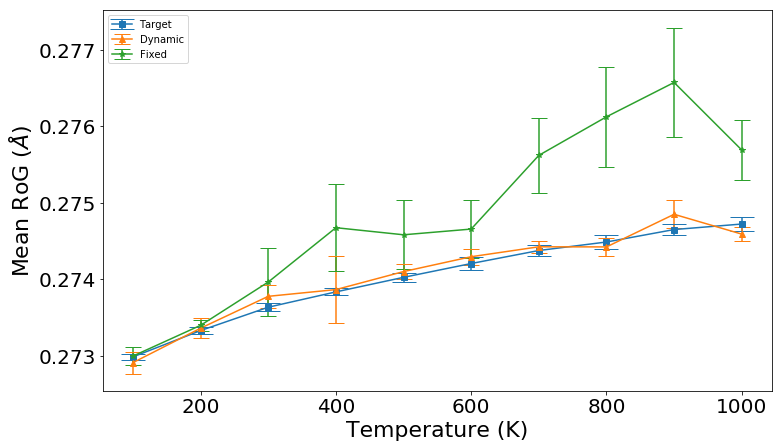

In [184]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(temps,rogs_median,yerr=rogs_std,label='Target', capsize=12.0, fmt="s-")
ax.errorbar(temps_dynLns,rogs_dynLns_median,yerr=rogs_dynLns_std,label='Dynamic', capsize=8.0, fmt="^-")
ax.errorbar(temps_SS,rogs_SS_median,yerr=rogs_SS_std,label='Fixed', capsize=8.0, fmt="*-")
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Mean RoG ($\AA$)')
#plt.savefig('Figures/meadian_ROG.pdf')
plt.savefig('Figures/mean_ROG.pdf')

## Mean Time vs Temperature

In [119]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
run_name = 'random-seed_runs/runtime_random-seeds/*'
path_str = '/'.join([root_path,run_name])
temp_hf_data =  defaultdict(list)
rs = defaultdict(list)
for d in glob.glob(path_str):
    hf = pd.read_csv(d).set_index("Temp[K]")
    for i in hf.index:
        temp_hf_data[i].append(float(hf.loc[i]))
        

In [120]:
temps_hf = []; runtime_hf_mean = []; runtime_hf_std = []
for i,k in temp_hf_data.items():
    temps_hf.append(float(i))
    runtime_hf_mean.append(np.mean(k))
    runtime_hf_std.append(np.std(k)/np.sqrt(len(k)))
    
temps_hf, runtime_hf_mean, runtime_hf_std = zip(
    *sorted(zip(temps_hf, runtime_hf_mean, runtime_hf_std))
)

## High Fidelity times dataframe

In [121]:
hf_times = pd.DataFrame(
    {
        "Temp[K]": np.array(temps_hf, dtype="int"),
        "Runtime[s]": runtime_hf_mean
    }
)


# Proxima

## Using Reference data

In [122]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## No reference data

In [123]:
results_true = {n: None for n in experiments_true}
for name in results_true:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_true[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## Fixed Parameters - 0.3, 50
simple surrogate

In [124]:
results_ss = {n: None for n in experiment_ss}
for name in results_ss:
    path_str = "/".join([root_path, 'random-seed_runs',name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results_ss[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

In [125]:
def summary_speedup(results):
    data_temp = {}
    cols = ["speed_up", "time", "mae"]

    for i,k in results.items():
        data = k.set_index('temperature')
        for t in data.index:

            if t not in data_temp:
                data_temp[t] = defaultdict(list)

            record = data.loc[t]

            for col in cols:
                data_temp[t][col].append(float(record[col]))
    summary = defaultdict(list)
    for i, k in data_temp.items():
        summary["temps"].append(float(i))
        for col in cols:
            summary[col + "_mean"].append(np.mean(k[col]))
            summary[col + "_std"].append(np.std(k[col])/np.sqrt(len(k[col])))

    keys = ["temps"] + [k for k in summary.keys() if k != "temps"]
    result = list(zip(*sorted(zip(*[summary[k] for k in keys]))))
    for i, k in enumerate(keys):
        summary[k] = result[i]
    return summary

In [126]:
summary_with_ref = summary_speedup(results)
summary_no_ref = summary_speedup(results_true)
summary_noref_fixed = summary_speedup(results_ss)

In [127]:
## Harmonic mean of different cases
print('Proxima with reference', stat.harmonic_mean(summary_with_ref['speed_up_mean']))
print('Proxima with no ref. data', stat.harmonic_mean(summary_no_ref['speed_up_mean']))
print('Fixed parameters', stat.harmonic_mean(summary_noref_fixed['speed_up_mean']))


Proxima with reference 2.1493703839392335
Proxima with no ref. data 1.6470570310896486
Fixed parameters 2.331173836677802


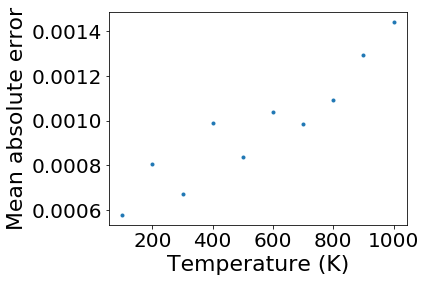

In [128]:
labels = list(summary_no_ref['temps'])
x = np.arange(len(labels)) 
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xlabel("Temperature (K)", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.plot(summary_no_ref['temps'],summary_no_ref['mae_mean'], '.')

plt.tight_layout()

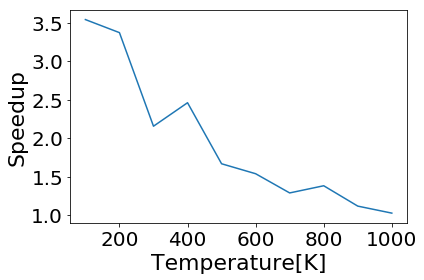

In [129]:
labels = list(summary_no_ref['temps'])
x = np.arange(len(labels)) 
plt.ylabel('Speedup', fontsize=BIG)
plt.xlabel("Temperature[K]", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.plot(summary_no_ref['temps'],summary_no_ref['speed_up_mean'])

plt.tight_layout()

## Comparing Speed-ups Proxima versions
Reference data vs no ref. data vs fixed surrogate without reference data

In [130]:
from scipy.stats import sem

def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(summary_no_ref['temps'])

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    
    #find error
    
    rects1 = ax.bar(x - WIDTH/2, list(_speedup_da), WIDTH,yerr=sem(list(_speedup_da)), label='Ref Data')
    rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa), WIDTH,yerr=sem(list(_speedup_sa)), label='No Ref Data')
    if RI:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ss300), WIDTH,yerr=sem(list(_speedup_ss300)), label=r'Fixed, $T$=0.3, $RI$=50')
    else:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ssnort), WIDTH,yerr=sem(list(_speedup_ssnort)), label=r'Fixed, $T$=0.3, $RI$=50')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    """if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')"""

    plt.show()

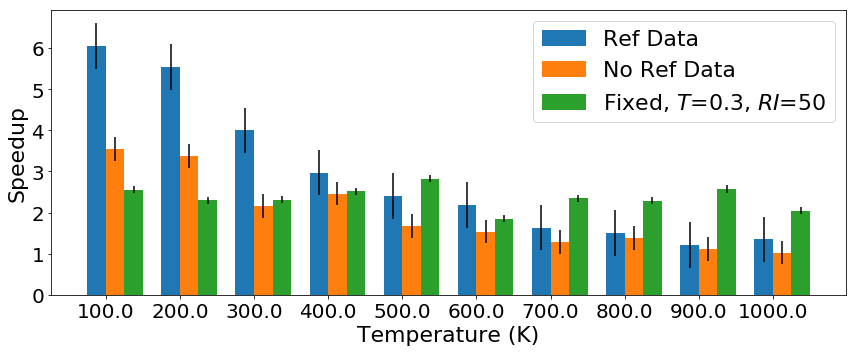

In [131]:
graph_speedup(False, summary_with_ref['speed_up_mean'], summary_no_ref['speed_up_mean'], None,summary_noref_fixed['speed_up_mean'])

## Speedups of Proxima vs Fixed
No Reference data

In [132]:
def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(summary_no_ref['temps'])

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    
    #calculating error
    
    rects1 = ax.bar(x - WIDTH/2, list(_speedup_da['speed_up_mean']), WIDTH,yerr=_speedup_da['speed_up_std'], label='Proxima - No Ref. Data')
    rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa['speed_up_mean']), WIDTH,yerr=_speedup_sa['speed_up_std'] ,label='Fixed - No Ref. Data')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    """if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')"""
    plt.savefig('Figures/speedup_noref.pdf')
    plt.show()

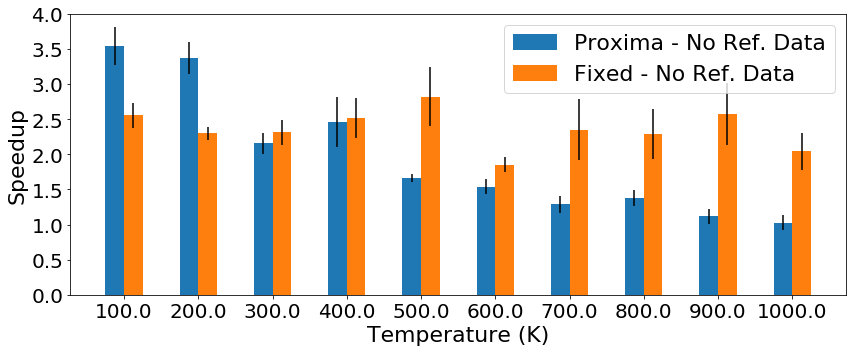

In [133]:
graph_speedup(False, summary_no_ref,summary_noref_fixed ,None, None)

In [134]:
import statistics
print("harmonic mean speedup", statistics.harmonic_mean(summary_no_ref['speed_up_mean']))
print(summary_no_ref['speed_up_mean'])
print(summary_noref_fixed['speed_up_mean'])
summary_noref_fixed['speed_up_mean']

harmonic mean speedup 1.6470570310896486
(3.5403000000000007, 3.3706000000000005, 2.1548, 2.4599, 1.6667999999999998, 1.5373999999999999, 1.2877999999999998, 1.3811, 1.1166, 1.0255)
(2.5544000000000002, 2.2991, 2.3131, 2.518, 2.8199, 1.8544000000000005, 2.3517, 2.2913, 2.5725000000000002, 2.0428)


(2.5544000000000002,
 2.2991,
 2.3131,
 2.518,
 2.8199,
 1.8544000000000005,
 2.3517,
 2.2913,
 2.5725000000000002,
 2.0428)

## MAE of results

In [211]:
def mae_results(summary1,summary2):
    RI= True #set true or false depending on retrain interval usage
    SS = False #Comparing with simple surrogate

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x - WIDTH/2, list(summary1['mae_mean']), WIDTH,yerr=summary1['mae_std'], label=r'Proxima - no Ref. Data')
    rects2 = ax.bar(x + WIDTH/2, list(summary2['mae_mean']), WIDTH, yerr=summary2['mae_std'],label='Fixed - no Ref. Data')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Energy MAE (eV)', fontsize=BIG)
    ax.set_xlabel("Temperature (K)", fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    ##plt.savefig('Figures/MAE_noref.pdf')

In [212]:
summary_noref_fixed['mae_mean']


(0.0004253,
 0.0009149000000000001,
 0.0007543000000000001,
 0.0012312,
 0.0014977999999999999,
 0.0011285,
 0.0017274,
 0.0017179,
 0.0021551,
 0.0022607)

In [213]:
#(0.0022607 - 0.002)
(0.002-0.0022607 )/(0.002)

-0.13035

In [225]:
summary_no_ref['mae_mean']

(0.0005786999999999999,
 0.0008075000000000001,
 0.0006734,
 0.0009908999999999999,
 0.0008378,
 0.0010395,
 0.0009869000000000002,
 0.0010934,
 0.0012927,
 0.0014411999999999997)

In [224]:
max(summary_no_ref['mae_mean'])

0.0014411999999999997

In [214]:
np.mean(summary_no_ref['mae_mean'])

0.0009742

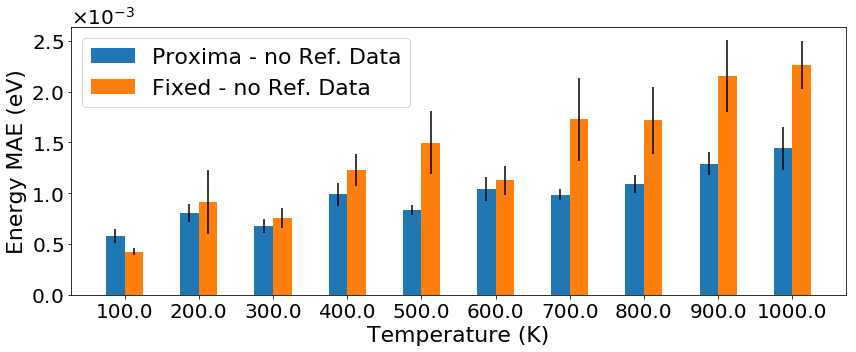

In [215]:
mae_results(summary_no_ref,summary_noref_fixed)

In [216]:
def ROG_mae_results(summary1,summary2):
    RI= True #set true or false depending on retrain interval usage
    SS = False #Comparing with simple surrogate

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x - WIDTH/2, list(summary1['mae_mean']), WIDTH,label=r'Proxima - no Ref. Data')
    rects2 = ax.bar(x + WIDTH/2, list(summary2['mae_mean']), WIDTH,label='Fixed - no Ref. Data')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean absolute error', fontsize=BIG)
    ax.set_xlabel("Temperature (K)", fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    #plt.savefig('Figures/3prox_MAEbar.pdf')

In [217]:
temp_rg = rog_hf.keys()

In [218]:
pd.DataFrame({'Temperature': [k for k in temp_rg]})
# k for k in rog_hf.keys() if k != "list"

,Temperature
0,400
1,300
2,500
3,100
4,200
5,900
6,600
7,800
8,700
9,1000


In [219]:
#rog_summary = pd.DataFrame(k for k in rog_hf.keys() if k != "list")
rog_summary = pd.DataFrame({'Temperature': [k for k in rog_hf.keys()]})
for name, d in [('Dynamic',rog_dynLns), ('Target',rog_hf), ('Fixed',rog_SS)]:
    col_m = []; col_s = []
    
    for T in rog_summary['Temperature']:
        col_m.append(np.mean(d[T]))
        col_s.append(np.std(d[T])/np.sqrt(len(d[T])))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mean"] = col_m
    rog_summary[f"{name}_stderr"] = col_s

In [220]:
rog_summary['T'] = rog_summary['Temperature'].astype('int')
rog_summary = rog_summary.sort_values('T')

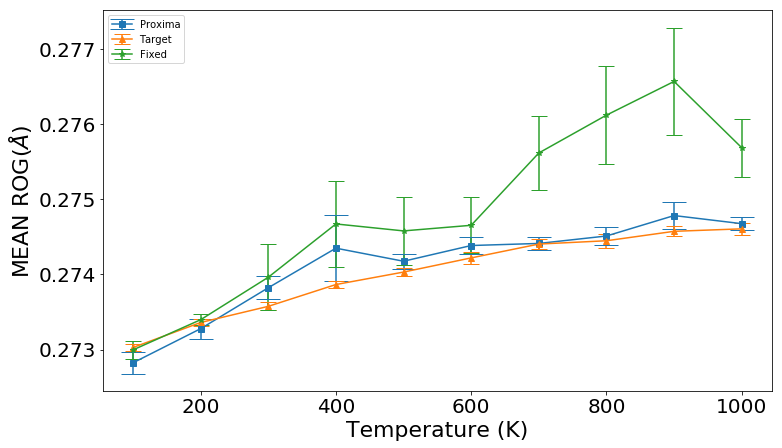

In [221]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)

ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mean'],yerr=rog_summary['Dynamic_stderr'],label='Proxima', capsize=12.0, fmt="s-")
ax.errorbar(rog_summary['T'],rog_summary['Target_mean'],yerr=rog_summary['Target_stderr'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mean'],yerr=rog_summary['Fixed_stderr'], label='Fixed',capsize=8.0, fmt="*-")

"""ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mean'],label='Dynamic', capsize=12.0, fmt="s-")
ax.errorbar(rog_summary['T'],rog_summary['Target_mean'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mean'], label='Fixed',capsize=8.0, fmt="*-")"""
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('MEAN ROG($\AA$)')
#plt.savefig('~/Desktop/mean_ROG.pdf')
plt.savefig('Figures/mean_ROG.pdf')

In [222]:
(0.274575-0.276573)/0.274575

-0.007276700355094236

In [194]:
rog_summary['Fixed_mean']

3    0.272995
4    0.273397
1    0.273963
0    0.274673
2    0.274581
6    0.274655
8    0.275619
7    0.276124
5    0.276573
9    0.275689
Name: Fixed_mean, dtype: float64

In [195]:
rog_summary['Dynamic_mean']

3    0.272823
4    0.273278
1    0.273823
0    0.274350
2    0.274177
6    0.274386
8    0.274414
7    0.274513
5    0.274785
9    0.274677
Name: Dynamic_mean, dtype: float64

In [196]:
rog_summary['Target_mean']

3    0.273027
4    0.273360
1    0.273575
0    0.273866
2    0.274032
6    0.274221
8    0.274405
7    0.274450
5    0.274575
9    0.274608
Name: Target_mean, dtype: float64

## GETTING MAE

In [197]:
#rog_summary = pd.DataFrame(k for k in rog_hf.keys() if k != "list")
rog_summary = pd.DataFrame({'Temperature': [k for k in rog_hf.keys()]})

for name, d in [('Target',rog_hf)]:
    col_m = []; col_s = []
    
    for T in rog_summary['Temperature']:
        col_m.append(np.mean(d[T]))
        col_s.append(np.std(d[T])/np.sqrt(len(d[T])))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mean"] = col_m
    #rog_summary[f"{name}_stderr"] = col_s

rog_summary["T"] = rog_summary['Temperature']
rog_summary = rog_summary.set_index("T") 
for name, d in [('Dynamic',rog_dynLns), ('Fixed',rog_SS)]:
    col_m = []; col_s = []
    for T in rog_summary['Temperature']:
        
        #import pdb; pdb.set_trace()
        size = len(d[T])
        dT = np.array(d[T])
        ref = np.array([rog_summary["Target_mean"].loc[T]] * size)
        
        ae = abs(dT - ref) / ref
        
        col_m.append(np.mean(ae))
        col_s.append(np.std(ae)/np.sqrt(size))
    #import pdb; pdb.set_trace()
    rog_summary[f"{name}_mae"] = col_m
    rog_summary[f"{name}_stderr"] = col_s

In [198]:
rog_summary.reset_index(drop=False,inplace=True)
rog_summary['T'] = rog_summary['Temperature'].astype('int')
rog_summary = rog_summary.sort_values('T')

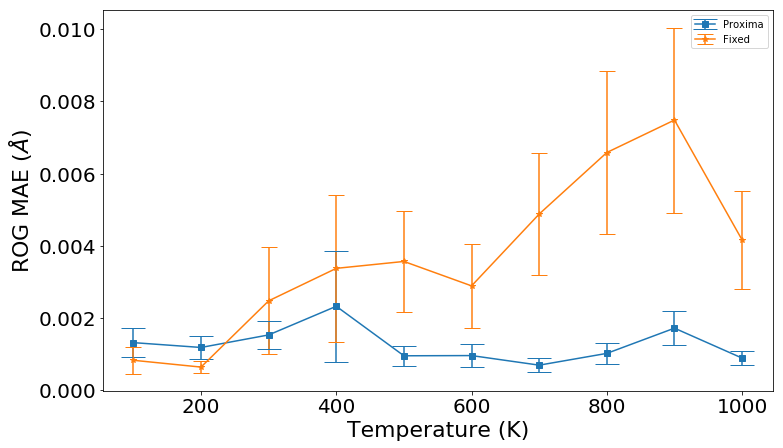

In [199]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(rog_summary['T'],rog_summary['Dynamic_mae'],yerr=rog_summary['Dynamic_stderr'],label='Proxima', capsize=12.0, fmt="s-")
#ax.errorbar(rog_summary['T'],rog_summary['Target_mae'],yerr=rog_summary['Target_stderr'],label='Target', capsize=8.0, fmt="^-")
ax.errorbar(rog_summary['T'],rog_summary['Fixed_mae'],yerr=rog_summary['Fixed_stderr'], label='Fixed',capsize=8.0, fmt="*-")
#ax.errorbar(temps,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('ROG MAE ($\AA$)')
plt.savefig('Figures/MAE_ROG.pdf')

In [200]:
rog_summary['Dynamic_mae']

3    0.001323
4    0.001189
1    0.001536
0    0.002329
2    0.000959
6    0.000965
8    0.000699
7    0.001025
5    0.001724
9    0.000895
Name: Dynamic_mae, dtype: float64

In [206]:
statistics.harmonic_mean(rog_summary['Dynamic_mae'])

0.001128781903014174

In [209]:
statistics.harmonic_mean(rog_summary['Fixed_mae'])

0.0020827035544326348

In [203]:
rog_summary['Fixed_mae']

3    0.000835
4    0.000646
1    0.002480
0    0.003379
2    0.003570
6    0.002894
8    0.004883
7    0.006586
5    0.007484
9    0.004165
Name: Fixed_mae, dtype: float64

In [204]:
0.007484/0.001724

4.341067285382831

In [ ]:
## MAE - the mean of the absolute error of each trial compared to the mean of the target 
## MEAN ROG - comparing the average of ROG all trials
## MEDIAN ROG - looking at median of results to reduce effects of outliers

In [ ]:
## Showing that Dynamic is capturing dynamic ROG and FIXED is not. 

## Testing thresholds

In [80]:
thresholds = [0.0005,0.001,0.002,0.004,0.006]
mae_vals = [0.000066,0.000576,0.001550,0.002577,0.002267]
times = [6171,666.8018,279.8098,116.0945,95.8729]
hf_time = 530 #average time

"""norm = np.linalg.norm(mae_vals)
norm_array = mae_vals/norm
norm_array"""
nom_error = [m/t for m,t in zip(mae_vals,thresholds)]

In [81]:
speedup = [hf_time/x for x in times]
speedup


[0.08588559390698428,
 0.7948388861577759,
 1.8941438076865071,
 4.565246415635539,
 5.528152376740455]

## Speedup

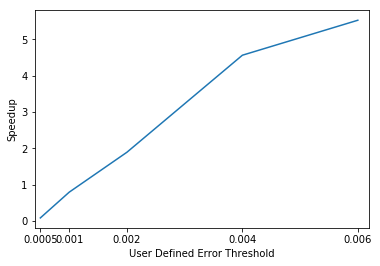

In [82]:
thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
plt.plot(thresholds,speedup)
plt.ylabel('Speedup')
plt.xlabel('User Defined Error Threshold')
plt.xlim(0.0004,0.0062)
plt.xticks(thresholds,thres)
plt.show()

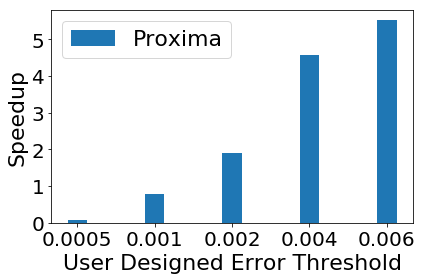

In [83]:
thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
labels = list(thres)
fig,ax = plt.subplots()
x = np.arange(len(labels))

rects1 = ax.bar(x,speedup, WIDTH, label='Proxima')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xlabel('User Designed Error Threshold', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()
plt.savefig('Figures/speedup_UQ_range.pdf')
plt.show()


## Normalized Error

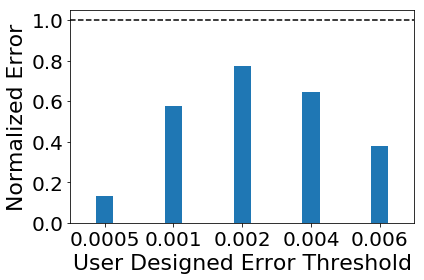

In [164]:
thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
labels = list(thres)
fig,ax = plt.subplots()
x = np.arange(len(labels))

rects1 = ax.bar(x,nom_error, WIDTH, label='Proxima')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized Error', fontsize=BIG)
ax.set_xlabel('User Designed Error Threshold', fontsize=BIG)

threshold = 1

ax.set_xticks(x)
ax.plot([-0.5,4.5],[1,1],"k--")
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
#ax.legend(fontsize=BIG)

ax.set_xlim([-0.5, 4.5])

plt.tight_layout()
plt.savefig('Figures/normError_UQ_range.pdf')
plt.show()

## Combining graphs

In [153]:
type(nom_error)
type(speedup)
d = {'Speedup':speedup,'Normalized Error':nom_error}
df = pd.DataFrame(d)

In [236]:
df

,Speedup,Normalized Error
0,0.085886,0.132000
1,0.794839,0.576000
2,1.894144,0.775000
3,4.565246,0.644250
4,5.528152,0.377833


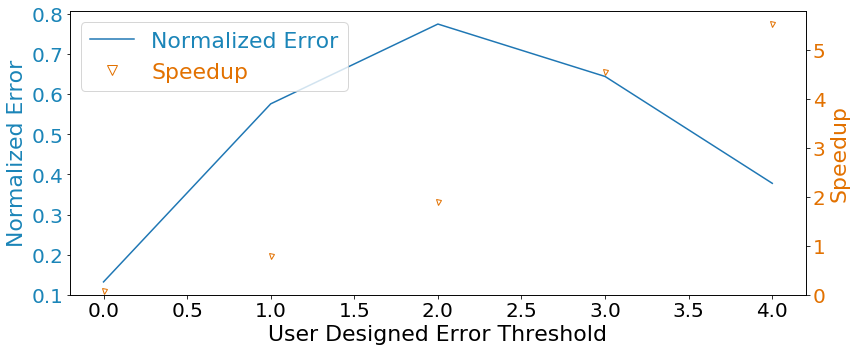

In [154]:
SPEEDUP_COLOR = colors[0]
NORMERROR_COLOR = colors[1]
SPEEDUP_LABEL = 'Speedup'
NORMERROR_LABEL = 'Normalized Error'
#temp = str(temp) # temperature to plot
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

p1, = plt.plot(x, nom_error,label=NORMERROR_LABEL)

#ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
#ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
h1, l1 = ax.get_legend_handles_labels()
ax.set_ylabel('Normalized Error', fontsize=BIG, color=NORMERROR_COLOR)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM, color=NORMERROR_COLOR)
#ax.set_ylim(0, 0.013)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.yaxis.get_offset_text().set_color(NORMERROR_COLOR)

ax2 = ax.twinx()
p2, = plt.plot(x, speedup, 'v', fillstyle='none', color=SPEEDUP_COLOR, markersize=5, label=SPEEDUP_LABEL)
ax2.set_ylabel('Speedup', fontsize=BIG, color=SPEEDUP_COLOR)
h2, l2 = ax2.get_legend_handles_labels()
ax2.set_ylim(bottom=0)
#ax2.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM, color=SPEEDUP_COLOR)
ax2.yaxis.get_offset_text().set_fontsize(MEDIUM)

ax.set_xlabel('User Designed Error Threshold', fontsize=BIG)

legend = plt.legend([p1, p2], [NORMERROR_LABEL, SPEEDUP_LABEL], markerscale=2, fontsize=BIG) # loc='upper left')
texts = legend.get_texts()
plt.setp(texts[0], color=NORMERROR_COLOR)
plt.setp(texts[1], color=SPEEDUP_COLOR)

plt.tight_layout()
#plt.savefig('Figures/'+variant+'_tolerance_and_alpha_'+temp+'K.pdf')
plt.show()





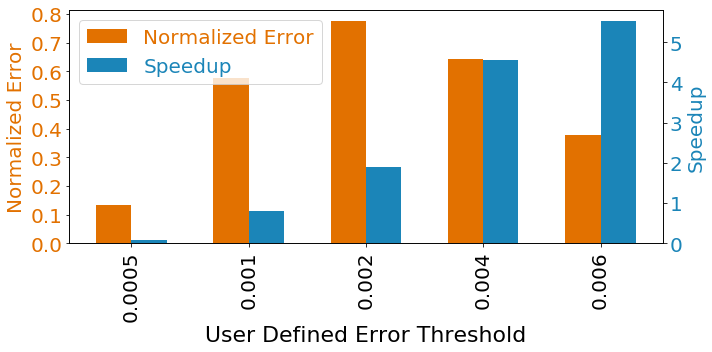

In [235]:
fig, ax = plt.subplots(figsize=(10,5))

thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
labels = list(thres)
ax1 = plt.subplot(1,1,1)
w = 0.3

plt.xticks(x+w/2, labels, rotation='vertical',fontsize=MEDIUM)

ax.set_xticklabels(labels,Fontsize=MEDIUM)
pop =ax1.bar(x, nom_error, width=w, color=NORMERROR_COLOR, align='center')
plt.ylabel('Normalized Error',fontsize=MEDIUM, color=NORMERROR_COLOR)
plt.yticks(fontsize=MEDIUM, color=NORMERROR_COLOR)

ax2 = ax1.twinx()
gdp =ax2.bar(x+w, speedup, width=w,color=SPEEDUP_COLOR,align='center')
plt.ylabel('Speedup',fontsize=MEDIUM, color=SPEEDUP_COLOR)
plt.yticks(fontsize=MEDIUM, color=SPEEDUP_COLOR)


legend = plt.legend([pop, gdp],['Normalized Error', 'Speedup'],fontsize=MEDIUM) # loc='upper left')
texts = legend.get_texts()
plt.setp(texts[0], color=NORMERROR_COLOR)
plt.setp(texts[1], color=SPEEDUP_COLOR)
#ax2.set_xlabel('User Designed Error Threshold', fontsize=BIG);
#plt.xlabel('User Designed Error Threshold', fontsize=BIG);
ax1.set_xlabel('User Defined Error Threshold', fontsize=BIG);

plt.tight_layout()
plt.savefig('Figures/uqthresh_normerror_speedup.pdf')

plt.show()

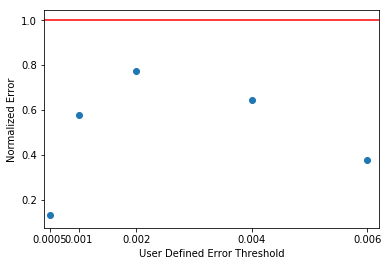

In [231]:
thres = ['0.0005', '0.001', '0.002', '0.004', '0.006']
plt.scatter(thresholds,nom_error)
plt.ylabel('Normalized Error')
plt.xlabel('User Defined Error Threshold')
plt.xlim(0.0004,0.0062)
plt.xticks(thresholds,thres)
plt.hlines(1,.0004,0.0062,colors='r',linestyles='solid')
plt.show()

In [55]:
## average uq time
(39.88+45.08+52.688+51.57+60.1388+52.33+59.404+54.404+54.589+63.7977+63.7977)/10

59.76791999999999